In [1]:
%matplotlib inline

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from numba import jit
from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

In [2]:
# Settings required in new code block due to an error in latest Jupyter version

sns.set()
matplotlib.rcParams["figure.dpi"] = 300
sns.set_palette("colorblind")

# City Construction

For my experiments, I will be using a 2D Numpy array with the first dimension being a pair of x-y coordinates of the city, and the second dimension being each city. The coordinates will be scaled between 0 and 1 and will be randomly generated with the array order being the path's order.

The two functions, `generate cities(n)` and `plot_cities(cities)` will be used as helper functions for the simulated annealing process.

In [53]:
# Cities are given as x-y pairs
@jit(nopython=True)
def generate_cities(n=30):
    cities = np.random.rand(n, 2)
    while len(np.unique(cities)) < n:
        cities = np.random.rand(n, 2)
        
    np.random.shuffle(cities)
    return cities

def plot_cities(results, suptitle="Simulated Annealing"):
    assert len(results) > 0, ("Cannot plot an empty chart")
    
    fig, axis = plt.subplots(2, 2, sharex=True, sharey=True)
    axis = axis.flatten()
    
    for index in range(len(results)):
        ax = axis[index]
        cities = results[index][0]
        title = results[index][1]
        
        sns.scatterplot(cities[:,0], cities[:,1], ax=ax)

        for index in range(len(cities)):
            city1 = cities[index-1]
            city2 = cities[index]

            x = (city1[0], city2[0])
            y = (city1[1], city2[1])

            sns.lineplot(x, y, linewidth="1.25", color="slategray", ax=ax)

        ax.set_title(f"{title}")
    
    axis[2].set_xlabel("City X-Coordinate")
    axis[2].set_ylabel("City Y-Coordinate")
    plt.subplots_adjust(top=0.88)
    plt.suptitle(f"Inter-City Connections for {len(cities)} Cities With {suptitle}", size=16, y=1.03)
    plt.show()
    
def plot_path_lengths(y_values, title="Simulated Annealing"):
    assert len(y_values) > 0, ("Cannot plot an empty chart")
    
    for y, tag in y_values:
        x = [x for x in range(len(y))]
        sns.lineplot(x, y, linewidth="1.", label=tag)
        
    plt.xlabel("Iterations")
    plt.ylabel("Path Length")
    plt.title(f"Path Length Over Time With {title}")
    plt.legend(loc="upper right")
    plt.show()

# Computing the cost of a combination

To compute the total length of a combination, I am computing the Euclidian distance between every city pair and sum the distances. I will not be computing the average, and will simply leave the distance as a total. This is something to watch out for when making comparisons with differing number of cities.

As with the code before, the two functions `distance(city1, city2)` and `error(cities)` will be used as helper functions for the simulated annealing process.

In [10]:
@jit(nopython=True)
def distance(city1, city2):
    return np.linalg.norm(city1 - city2)

@jit(nopython=True)
def error(cities):
    error = 0.0
    
    for index in range(len(cities)):
        city1 = cities[index-1]
        city2 = cities[index]
        error += distance(city1, city2)
        
    return error

# Below is an example showing what the four functions do

Total Distance With City Size  25: 13.2042
Total Distance With City Size  50: 27.1503
Total Distance With City Size  75: 36.1452
Total Distance With City Size 100: 52.6663


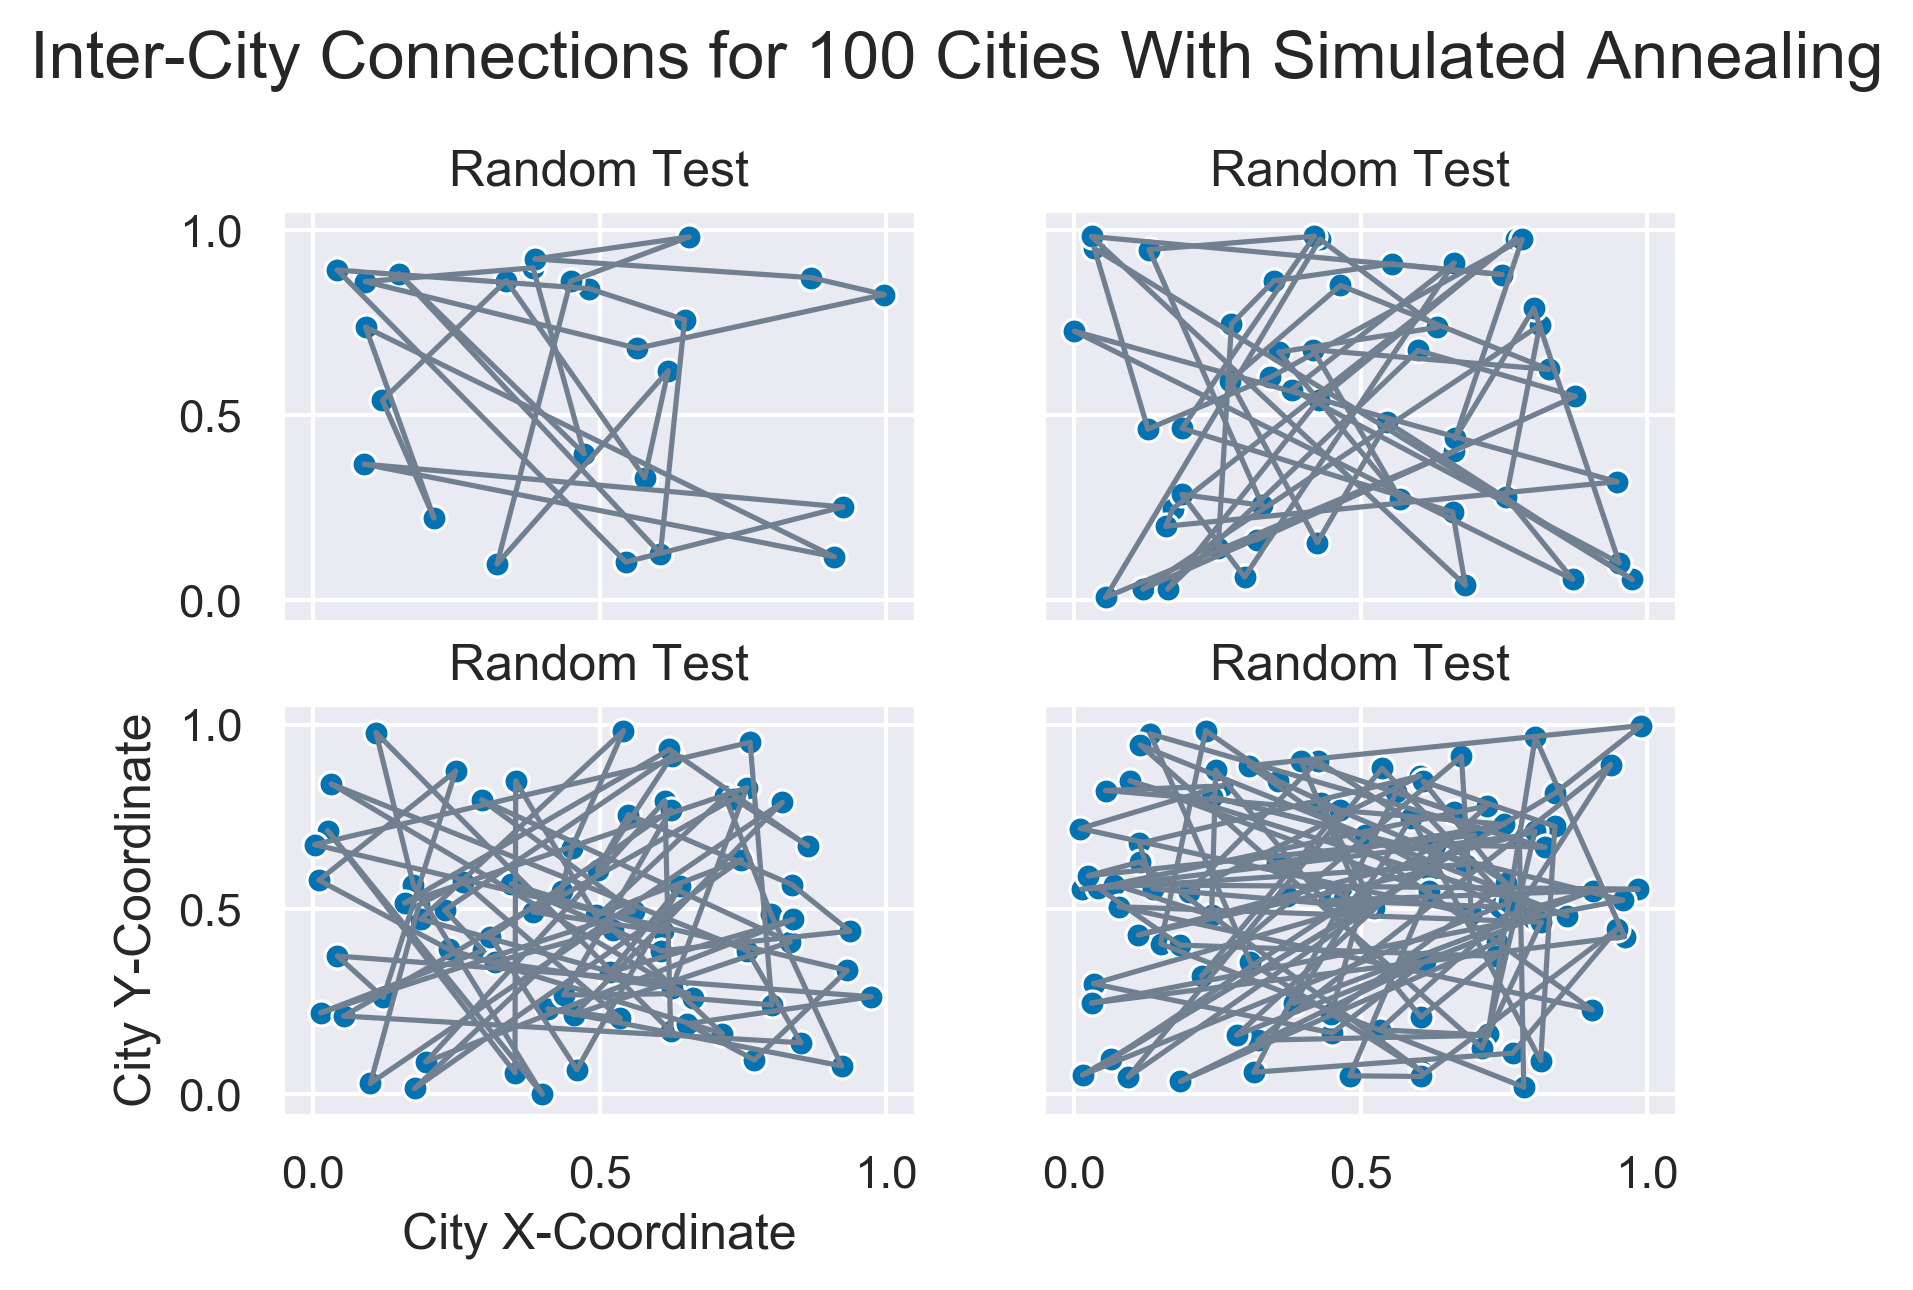

In [11]:
cities = [(generate_cities(n=n), "Random Test") for n in range(25, 125, 25)]
for city, _ in cities:
    print(f"Total Distance With City Size {len(city):3d}: {error(city):.4f}")
plot_cities(cities)

# General Annealing Function

Below is the form my experiments will take. The function takes a list of cities, a function that adjusts the connections, a function that adjusts the temperature, and a generator that determines when the annealing process is finished.

In [12]:
@jit(nopython=True)
def simulated_annealing(
    cities,
    annealing,
    cooling,
    finished,
    iterations=10_000,
    early_stopping=100,
    temperature=10,
    alpha=0.9
):
    
    expected_length = len(cities)
    
    initial_temperature = temperature

    path_lengths = []
    score = error(cities)
    path_lengths.append(score)
    
    while not finished(path_lengths, iterations, early_stopping):
        new_cities = cities.copy()
        annealing(new_cities)
        
        assert cities.shape[0] == expected_length, ("Duplicate City From Annealing")
        assert new_cities.shape[0] == expected_length, ("Duplicate City From Annealing")
        
        new_score = error(new_cities)
        
        improvement = score - new_score
        if np.random.rand() <= np.exp(improvement / temperature):
            cities = new_cities
            score = new_score
            
        temperature = cooling(temperature, iterations, initial_temperature, alpha=alpha)
        path_lengths.append(score)
        
    return path_lengths, cities

# Cooling Algorithm

Below are a few ideas I've had for cooling the temperature. The first is a simple linear decrease based on a number of iterations. The second is exponential, also based on the number of iterations.

In [13]:
@jit(nopython=True)
def cooling_linear(t, iterations, initial_temperature, alpha=0):
    return t - (initial_temperature / iterations)

@jit(nopython=True)
def cooling_decay(t, iterations, initial_temperature, alpha=2):
    return t * alpha ** (-initial_temperature / iterations)

# Stopping Algorithm

Below are a few ideas I've had for stopping conditions. The first is simply a count of iterations; stop after $n$ iterations. The second is a listener that stops when no improvement has been made over $n$ iterations.

In [27]:
@jit(nopython=True)
def finished_iterations(path_lengths, iterations, _):
    return len(path_lengths) > iterations
    
@jit(nopython=True)
def finished_no_improvements(path_lengths, iterations, no_improvements):
    if len(path_lengths) > iterations:
        return True

    if len(path_lengths) <= no_improvements:
        return False

    for index in range(no_improvements):
        if np.abs(path_lengths[-index-2] - path_lengths[-index-1]) > 0:
            return False

    return True

# Annealing Algorithm

Below are a few ideas for annealing. The first is a simple random shuffle of paths. The second uses Sub-Tour Reversal. The third randomly swaps cities. The fourth incorporates both methods.

### Sub-Tour Reversal

[..., 1, 2, 3, 4, ...] => [..., 4, 3, 2, 1, ...]

### Swap Cities

[..., 1, 2, 3, 4, ...] => [..., 4, 2, 3, 1, ...]

In [15]:
@jit(nopython=True)
def annealing_random(cities):
    np.random.shuffle(cities)

@jit(nopython=True)
def annealing_sub_tour(cities):
    city1 = np.random.randint(-len(cities), len(cities))
    city2 = np.random.randint(-len(cities), len(cities))
    
    if city1 > city2:
        city1, city2 = city2, city1
    
    cities[city1:city2+city1] = cities[city1:city2+city1][::-1]

@jit(nopython=True)
def annealing_swap_cities(cities):
    city1 = np.random.randint(len(cities))
    city2 = np.random.randint(len(cities))
    
    temp = cities[city1].copy()
    cities[city1] = cities[city2]
    cities[city2] = temp

@jit(nopython=True)
def annealing_sub_tour_and_swap(cities):
    annealing_sub_tour(cities)
    annealing_swap_cities(cities)

@jit(nopython=True)    
def annealing_swap_and_sub_tour(cities):
    annealing_swap_cities(cities)
    annealing_sub_tour(cities)

# Putting It All Together - pt.1

Below are a few experiments performed using the above algorithms. This section uses linear cooling with fixed iterations.

The first algorithm employs the 'Swap Cities' strategy. The second uses the 'Sub-Tour Reversal' approach. The third combines the two prior algorithms with the sub-tour occuring first followed by the random swap on each annealing step. The fourth is the same as the prior, but performs a swap first followed by a sub-tour reversal.

The two figures below show the results for a tour of 100 cities with 250,000 iterations. The first figure compares the three approaches while the second shows the final city connections with the four approaches.

In [21]:
%%time

cities = generate_cities(n=100)
iterations = 500_000
alpha=5

path_lengths_swap_cities_annealing, cities_swap_cities_annealing = simulated_annealing(
    cities,
    annealing_swap_cities,
    cooling_decay,
    finished_iterations,
    iterations=iterations,
    alpha=alpha,
)
path_lengths_sub_tour_annealing, cities_sub_tour_annealing = simulated_annealing(
    cities,
    annealing_sub_tour,
    cooling_decay,
    finished_iterations,
    iterations=iterations,
    alpha=alpha,
)
path_lengths_tour_swap_annealing, cities_tour_swap_annealing = simulated_annealing(
    cities,
    annealing_sub_tour_and_swap,
    cooling_decay,
    finished_iterations,
    iterations=iterations,
    alpha=alpha,
)
path_lengths_swap_tour_annealing, cities_swap_tour_annealing = simulated_annealing(
    cities,
    annealing_swap_and_sub_tour,
    cooling_decay,
    finished_iterations,
    iterations=iterations,
    alpha=alpha,
)

Wall time: 1min 4s


Final Distances For Each Algorithm...
Swap Cities     - 10.2769
Sub Tour        - 7.7814
Swap and Tour   - 8.6392
Tour and Swap   - 8.4703


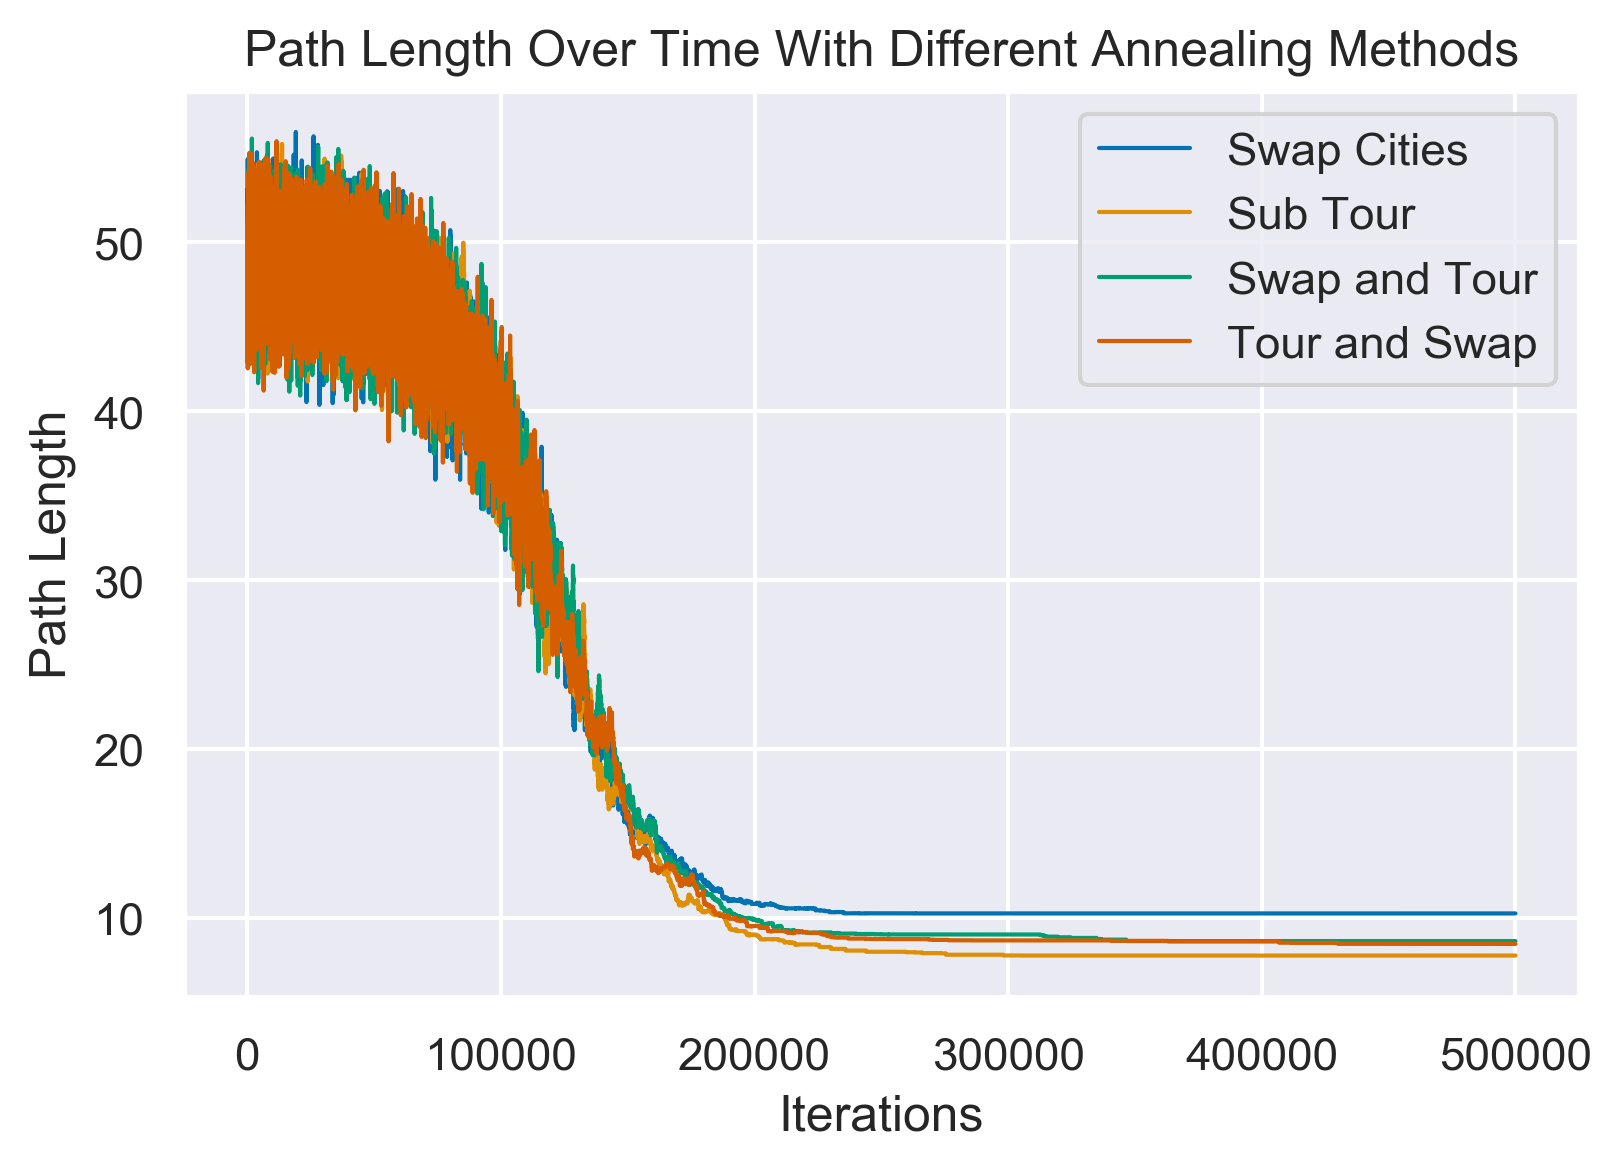

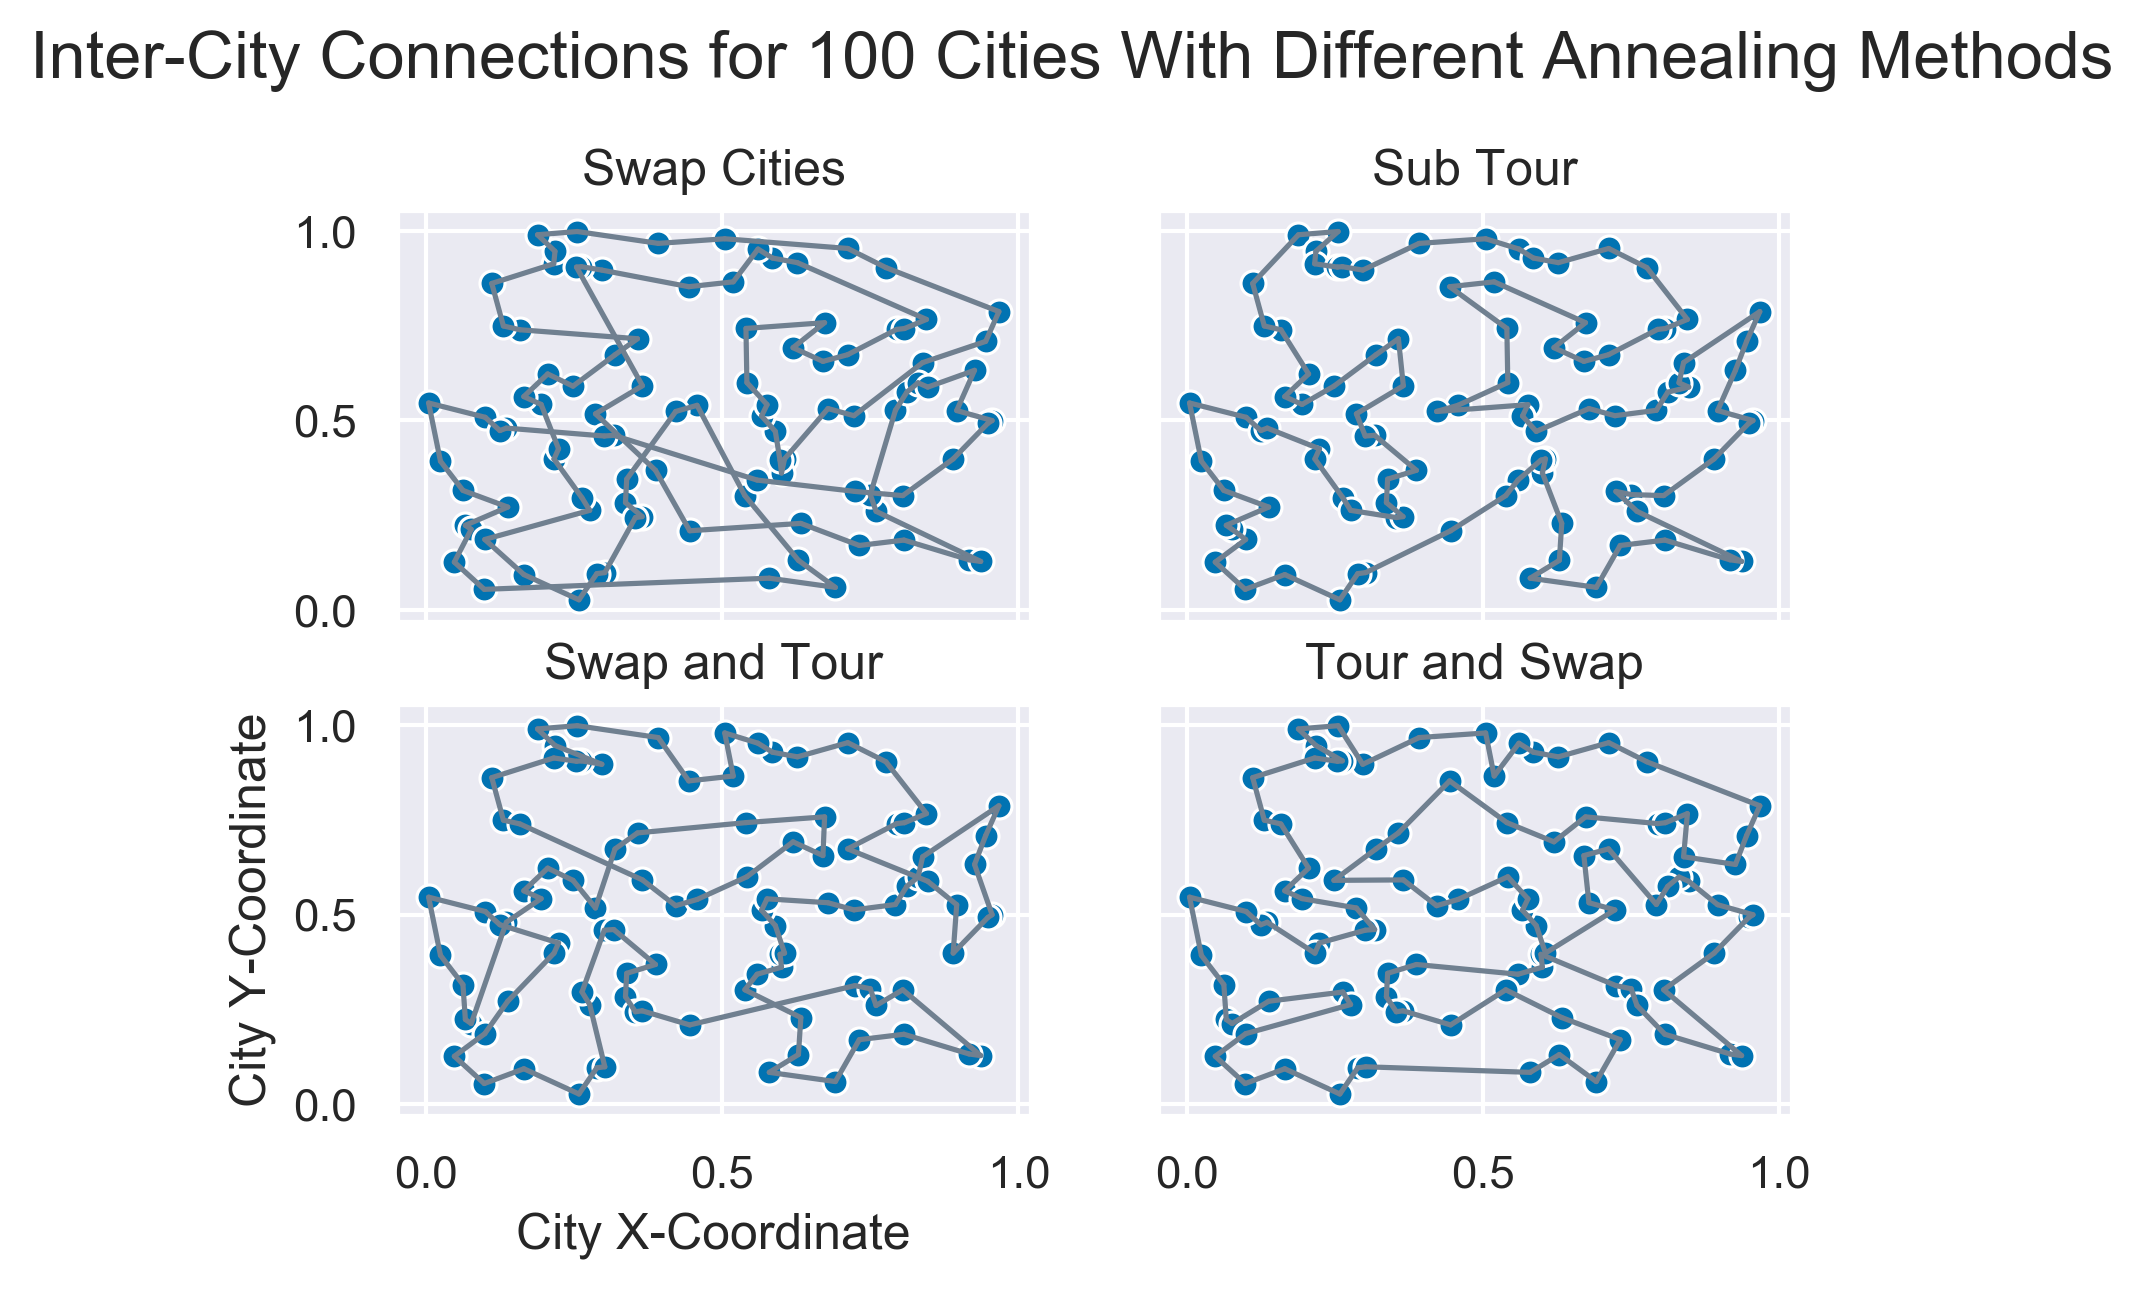

In [22]:
path_lengths = [
    (path_lengths_swap_cities_annealing, "Swap Cities"),
    (path_lengths_sub_tour_annealing, "Sub Tour"),
    (path_lengths_tour_swap_annealing, "Swap and Tour"),
    (path_lengths_swap_tour_annealing, "Tour and Swap"),
]

cities = [
    (cities_swap_cities_annealing, "Swap Cities"),
    (cities_sub_tour_annealing, "Sub Tour"),
    (cities_tour_swap_annealing, "Swap and Tour"),
    (cities_swap_tour_annealing, "Tour and Swap"),
]

print("Final Distances For Each Algorithm...")
for path in path_lengths:
    print(f"{path[1]:15s} - {path[0][-1]:.4f}")

plot_path_lengths(path_lengths, title="Different Annealing Methods")
plot_cities(cities, suptitle="Different Annealing Methods")

# Putting It All Together - pt.2

In this section, I do the same test as above, but set an early stopping condition. The early stopping condition will stop the annealing process if no changes are detected after 10,000 iterations.

In [30]:
%%time

cities = generate_cities(n=100)
iterations = 250_000
early_stopping = 10_000
alpha=5

path_lengths_swap_cities_annealing, cities_swap_cities_annealing = simulated_annealing(
    cities,
    annealing_swap_cities,
    cooling_decay,
    finished_no_improvements,
    iterations=iterations,
    early_stopping=early_stopping,
    alpha=alpha,
)
path_lengths_sub_tour_annealing, cities_sub_tour_annealing = simulated_annealing(
    cities,
    annealing_sub_tour,
    cooling_decay,
    finished_no_improvements,
    iterations=iterations,
    early_stopping=early_stopping,
    alpha=alpha,
)
path_lengths_tour_swap_annealing, cities_tour_swap_annealing = simulated_annealing(
    cities,
    annealing_sub_tour_and_swap,
    cooling_decay,
    finished_no_improvements,
    iterations=iterations,
    early_stopping=early_stopping,
    alpha=alpha,
)
path_lengths_swap_tour_annealing, cities_swap_tour_annealing = simulated_annealing(
    cities,
    annealing_swap_and_sub_tour,
    cooling_decay,
    finished_no_improvements,
    iterations=iterations,
    early_stopping=early_stopping,
    alpha=alpha,
)

Wall time: 25.6 s


Final Distances For Each Algorithm...
Swap Cities     - 10.5096
Sub Tour        - 7.9121
Swap and Tour   - 9.4719
Tour and Swap   - 9.7045


b:\applications\python3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


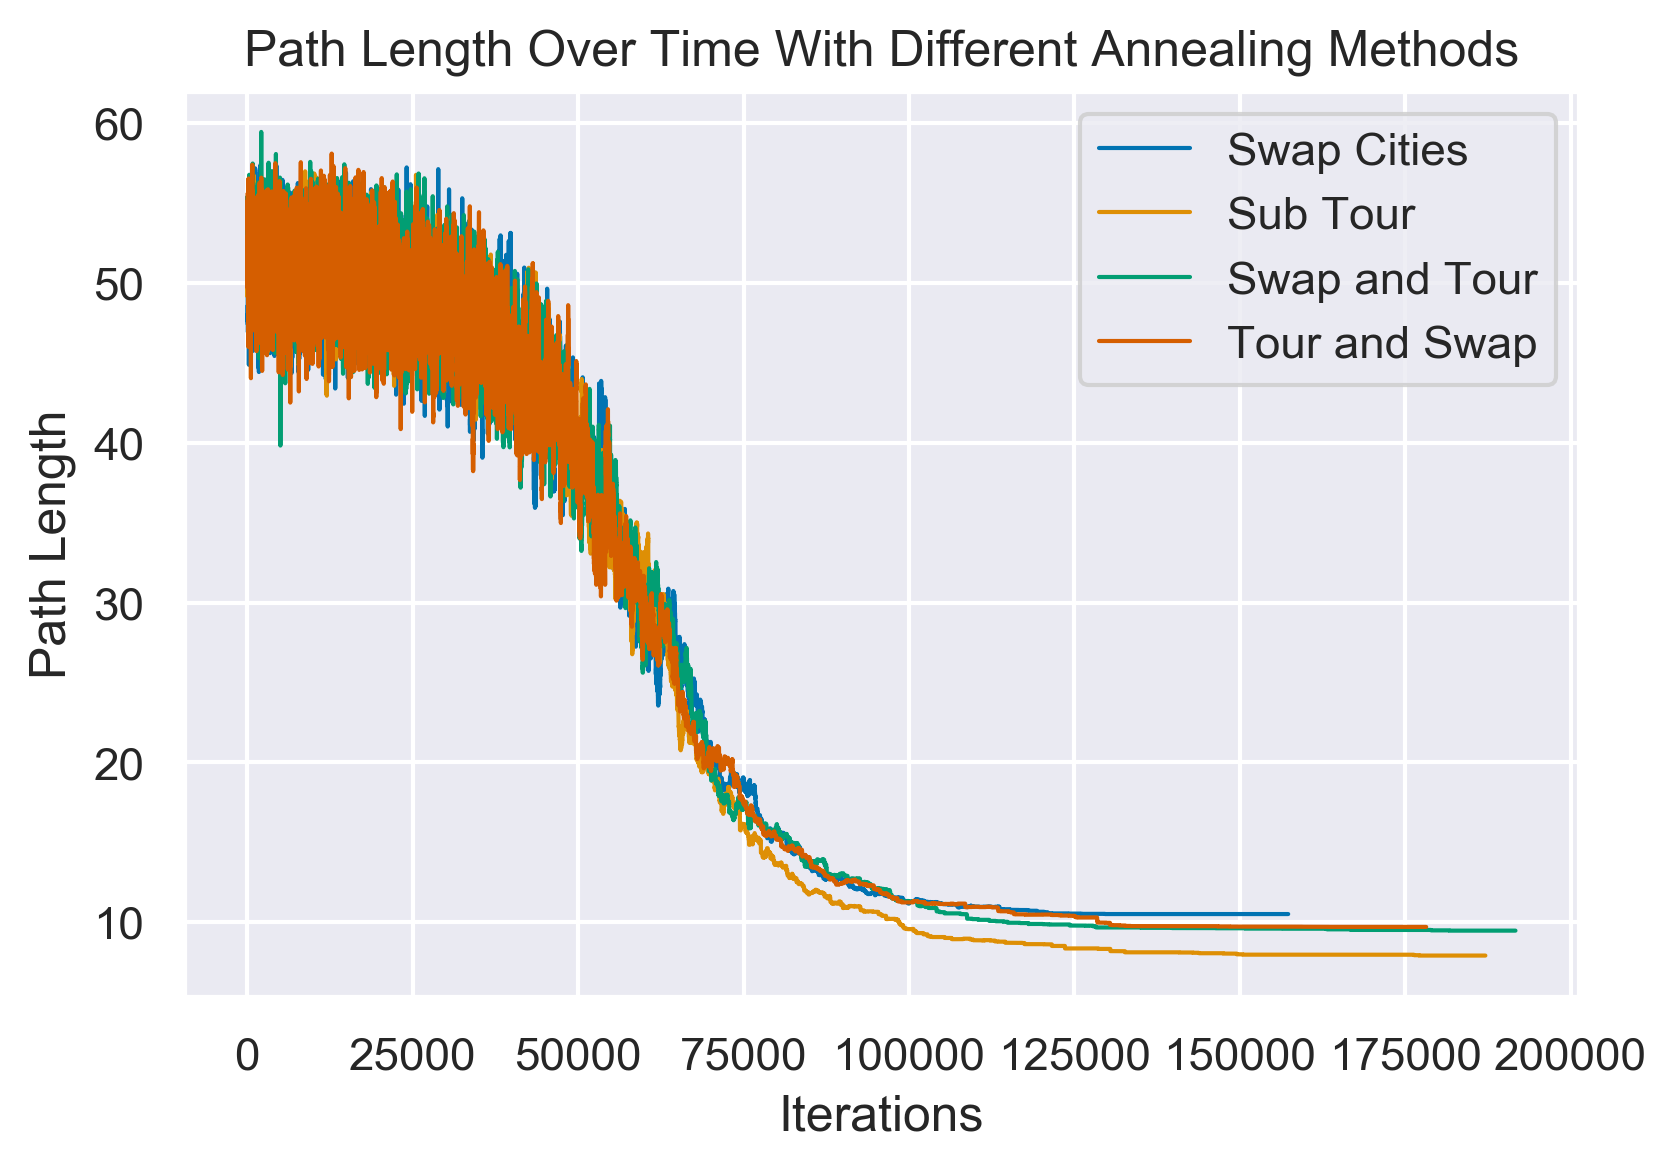

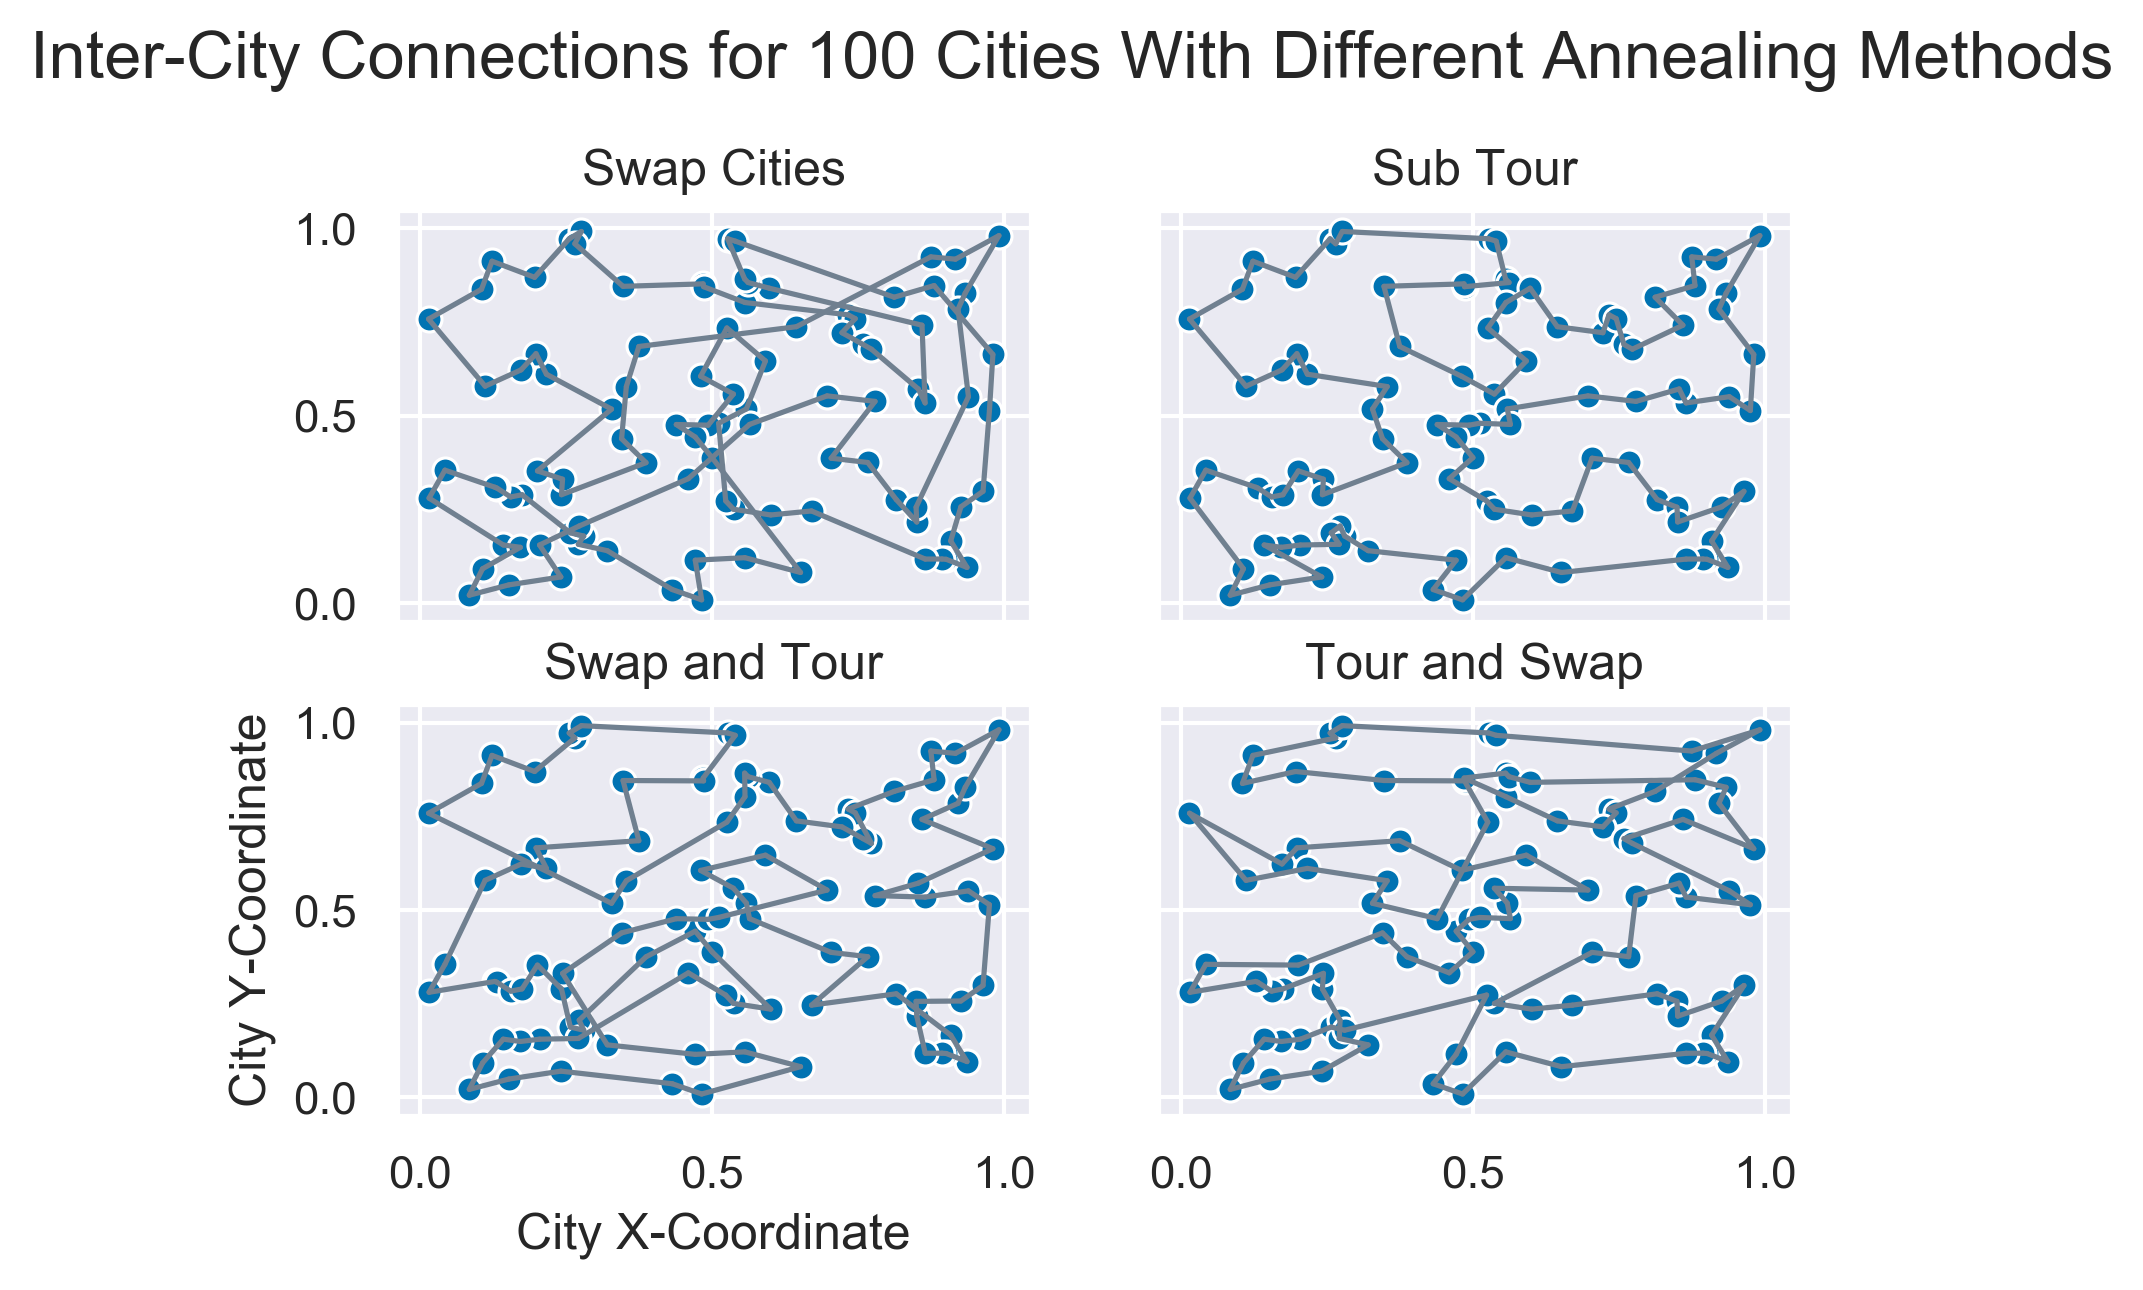

In [31]:
path_lengths = [
    (path_lengths_swap_cities_annealing, "Swap Cities"),
    (path_lengths_sub_tour_annealing, "Sub Tour"),
    (path_lengths_tour_swap_annealing, "Swap and Tour"),
    (path_lengths_swap_tour_annealing, "Tour and Swap"),
]

cities = [
    (cities_swap_cities_annealing, "Swap Cities"),
    (cities_sub_tour_annealing, "Sub Tour"),
    (cities_tour_swap_annealing, "Swap and Tour"),
    (cities_swap_tour_annealing, "Tour and Swap"),
]

print("Final Distances For Each Algorithm...")
for path in path_lengths:
    print(f"{path[1]:15s} - {path[0][-1]:.4f}")

plot_path_lengths(path_lengths, title="Different Annealing Methods")
plot_cities(cities, suptitle="Different Annealing Methods")

# Further Investigations

There are three interesting independent variables to experiment with: 1) the number of cities, 2) the initial temperature, and 3) the alpha decay.

For each independent variable, I use the prior setup with only sub-tour reversal. Using this setup, I test what changes to the independent variable does to both convergance speed, and final accuracy.

Results For Each Algorithm...
City Count (50)  | Distance -  5.5293 | Iterations - 250001
City Count (75)  | Distance -  7.1136 | Iterations - 234815
City Count (100) | Distance -  8.7390 | Iterations - 156867
City Count (125) | Distance -  9.9860 | Iterations - 147292


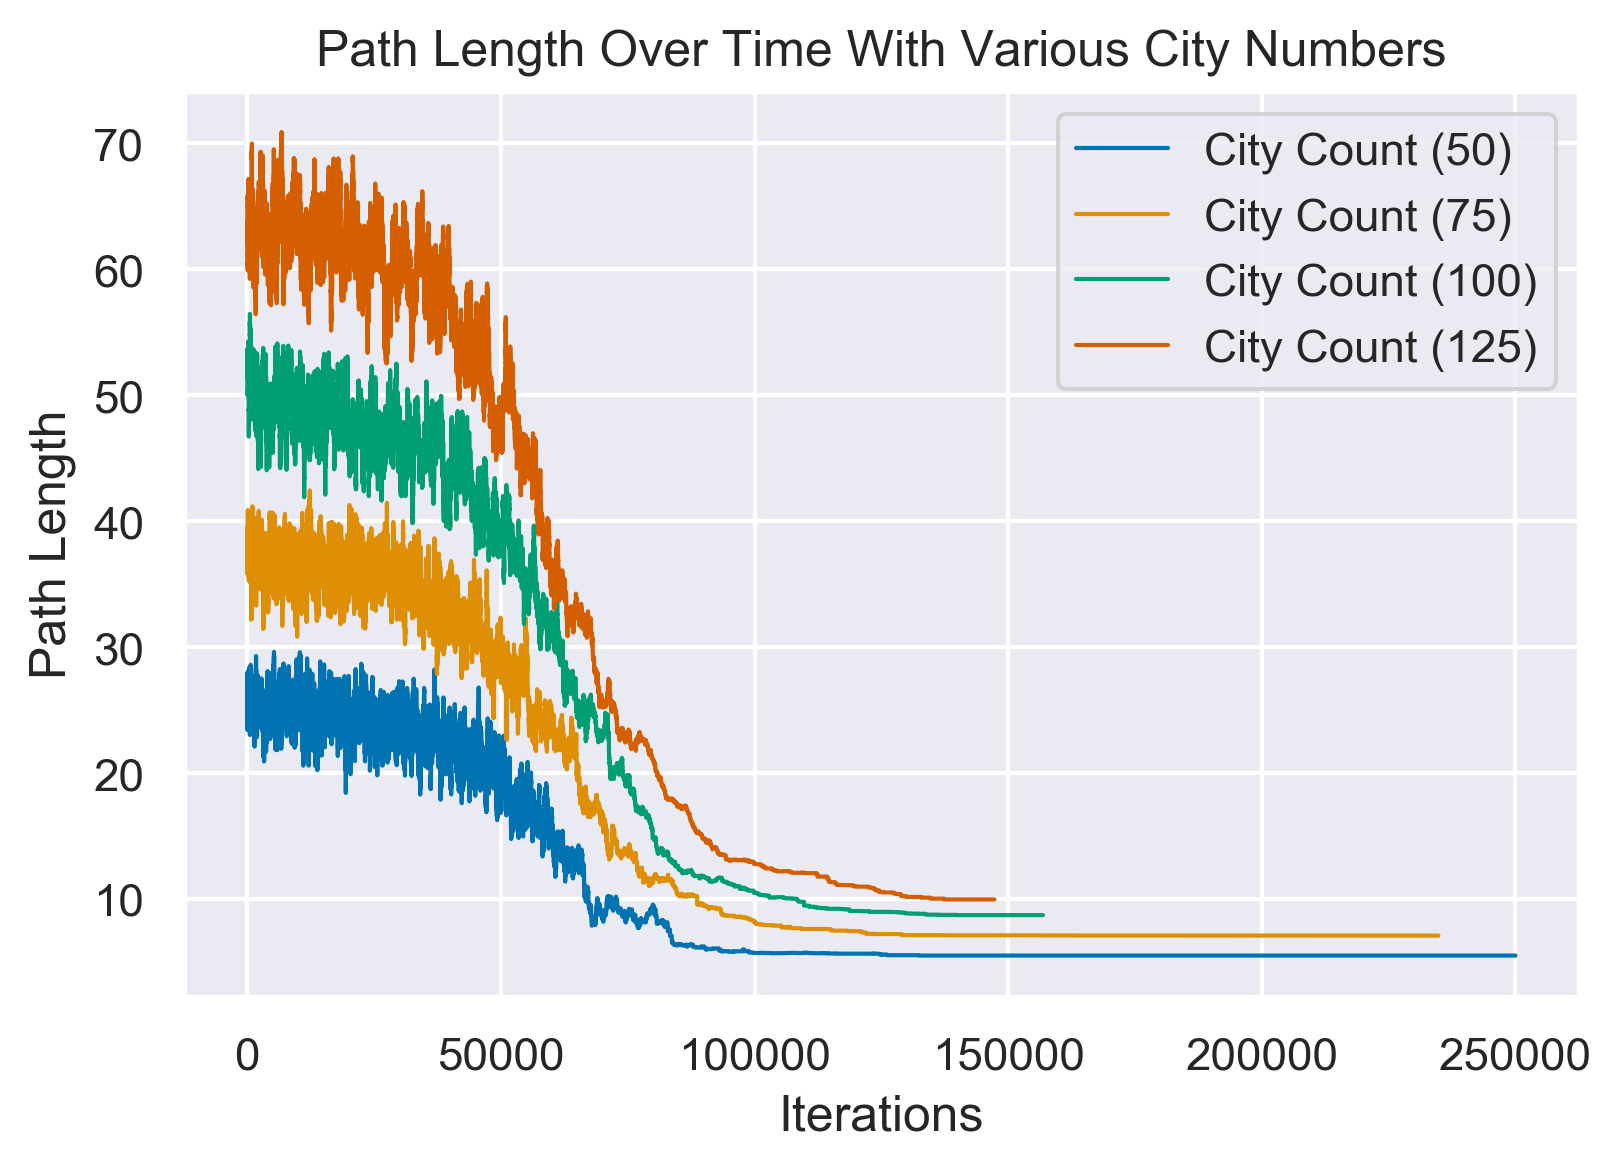

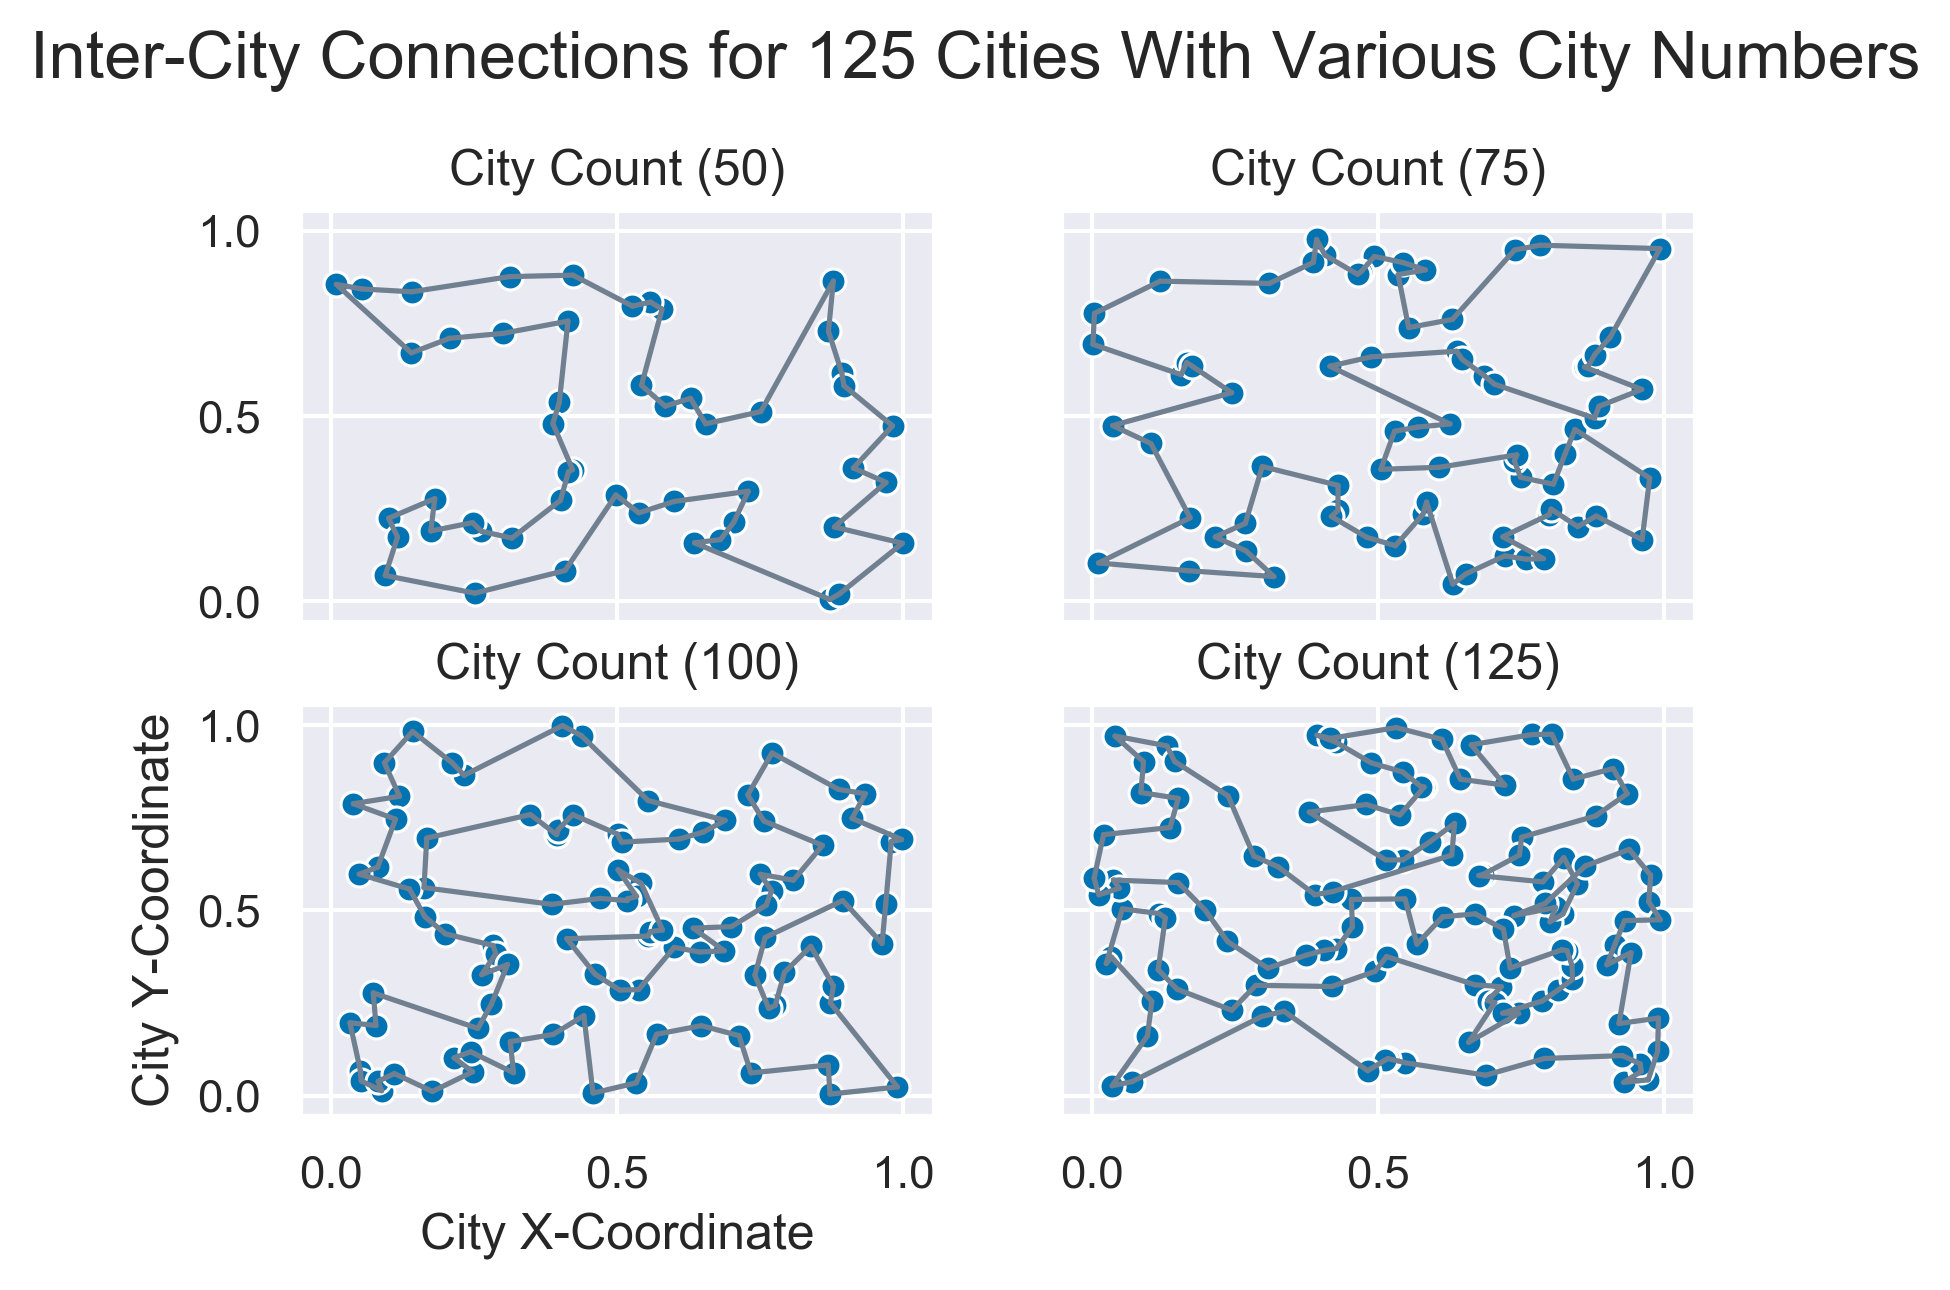

Wall time: 1min 23s


In [49]:
%%time

iterations = 250_000
early_stopping = 10_000
alpha=5

path_lengths = []
cities = []

for num_cities in range(50, 150, 25):
    path, city = simulated_annealing(
        generate_cities(n=num_cities),
        annealing_sub_tour,
        cooling_decay,
        finished_no_improvements,
        iterations=iterations,
        early_stopping=early_stopping,
        alpha=alpha,
    )

    path_lengths.append((path, f"City Count ({num_cities})"))
    cities.append((city, f"City Count ({num_cities})"))

print("Results For Each Algorithm...")
for path in path_lengths:
    print(f"{path[1]:16s} | Distance - {path[0][-1]:7.4f} | Iterations - {len(path[0]):d}")

plot_path_lengths(path_lengths, title="Various City Numbers")
plot_cities(cities, suptitle="Various City Numbers")

Results For Each Algorithm...
Init. Temp. (5)  | Distance -  7.9649 | Iterations - 250001
Init. Temp. (10) | Distance -  8.2912 | Iterations - 166903
Init. Temp. (15) | Distance -  8.5903 | Iterations - 144051
Init. Temp. (20) | Distance -  8.5984 | Iterations - 118641


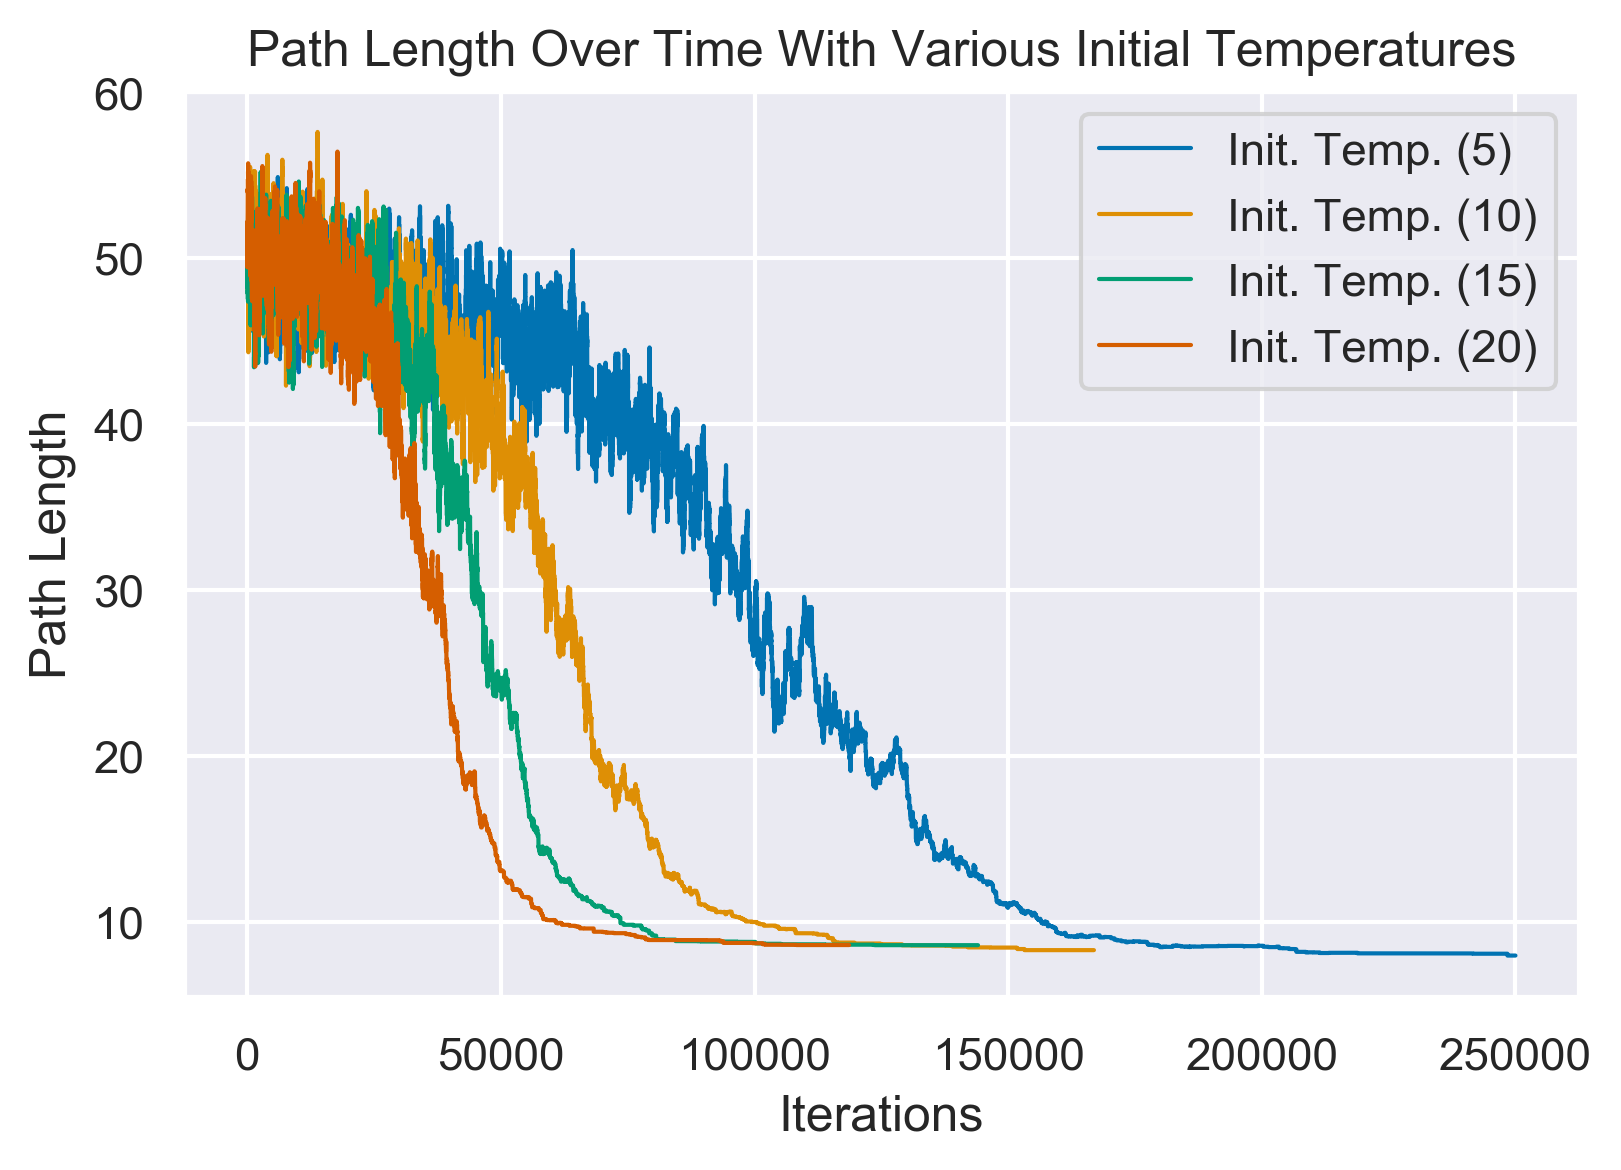

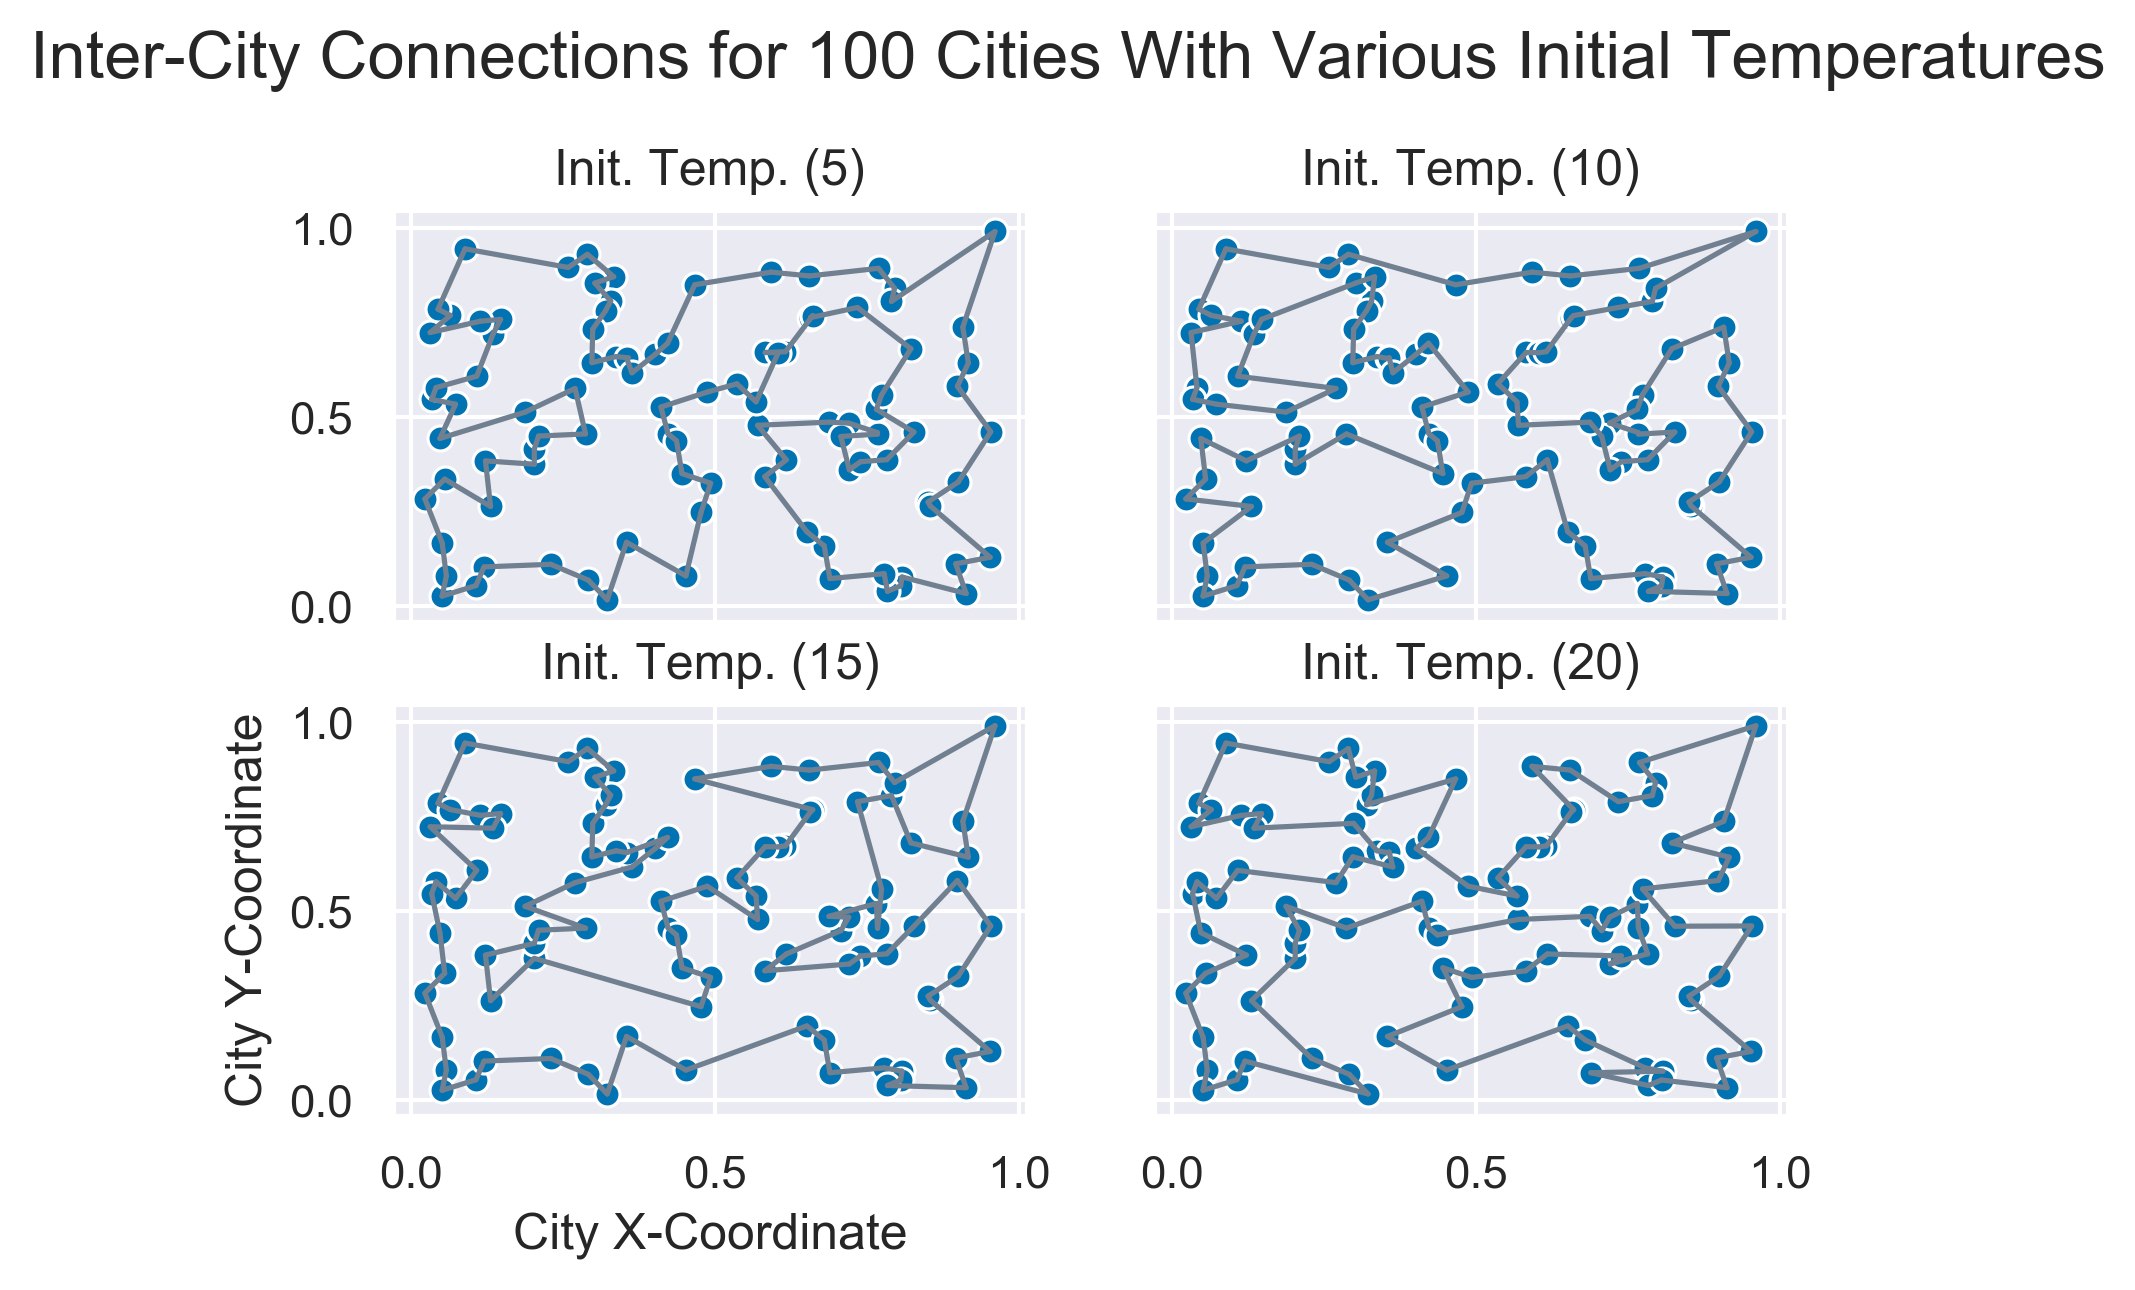

Wall time: 1min 16s


In [54]:
%%time

iterations = 250_000
early_stopping = 10_000
alpha=5

path_lengths = []
cities = []

base_city = generate_cities(n=100)

for initial_temperature in range(5, 25, 5):
    path, city = simulated_annealing(
        base_city,
        annealing_sub_tour,
        cooling_decay,
        finished_no_improvements,
        iterations=iterations,
        early_stopping=early_stopping,
        alpha=alpha,
        temperature=initial_temperature
    )

    path_lengths.append((path, f"Init. Temp. ({initial_temperature})"))
    cities.append((city, f"Init. Temp. ({initial_temperature})"))

print("Results For Each Algorithm...")
for path in path_lengths:
    print(f"{path[1]:16s} | Distance - {path[0][-1]:7.4f} | Iterations - {len(path[0]):d}")

plot_path_lengths(path_lengths, title="Various Initial Temperatures")
plot_cities(cities, suptitle="Various Initial Temperatures")

Results For Each Algorithm...
Alpha Value (1.5) | Distance - 28.8405 | Iterations - 250001
Alpha Value (3.0) | Distance -  8.7868 | Iterations - 236988
Alpha Value (4.5) | Distance -  8.6362 | Iterations - 171415
Alpha Value (6.0) | Distance -  8.5721 | Iterations - 142138
Alpha Value (7.5) | Distance -  8.7810 | Iterations - 133303
Alpha Value (9.0) | Distance -  8.4348 | Iterations - 124489


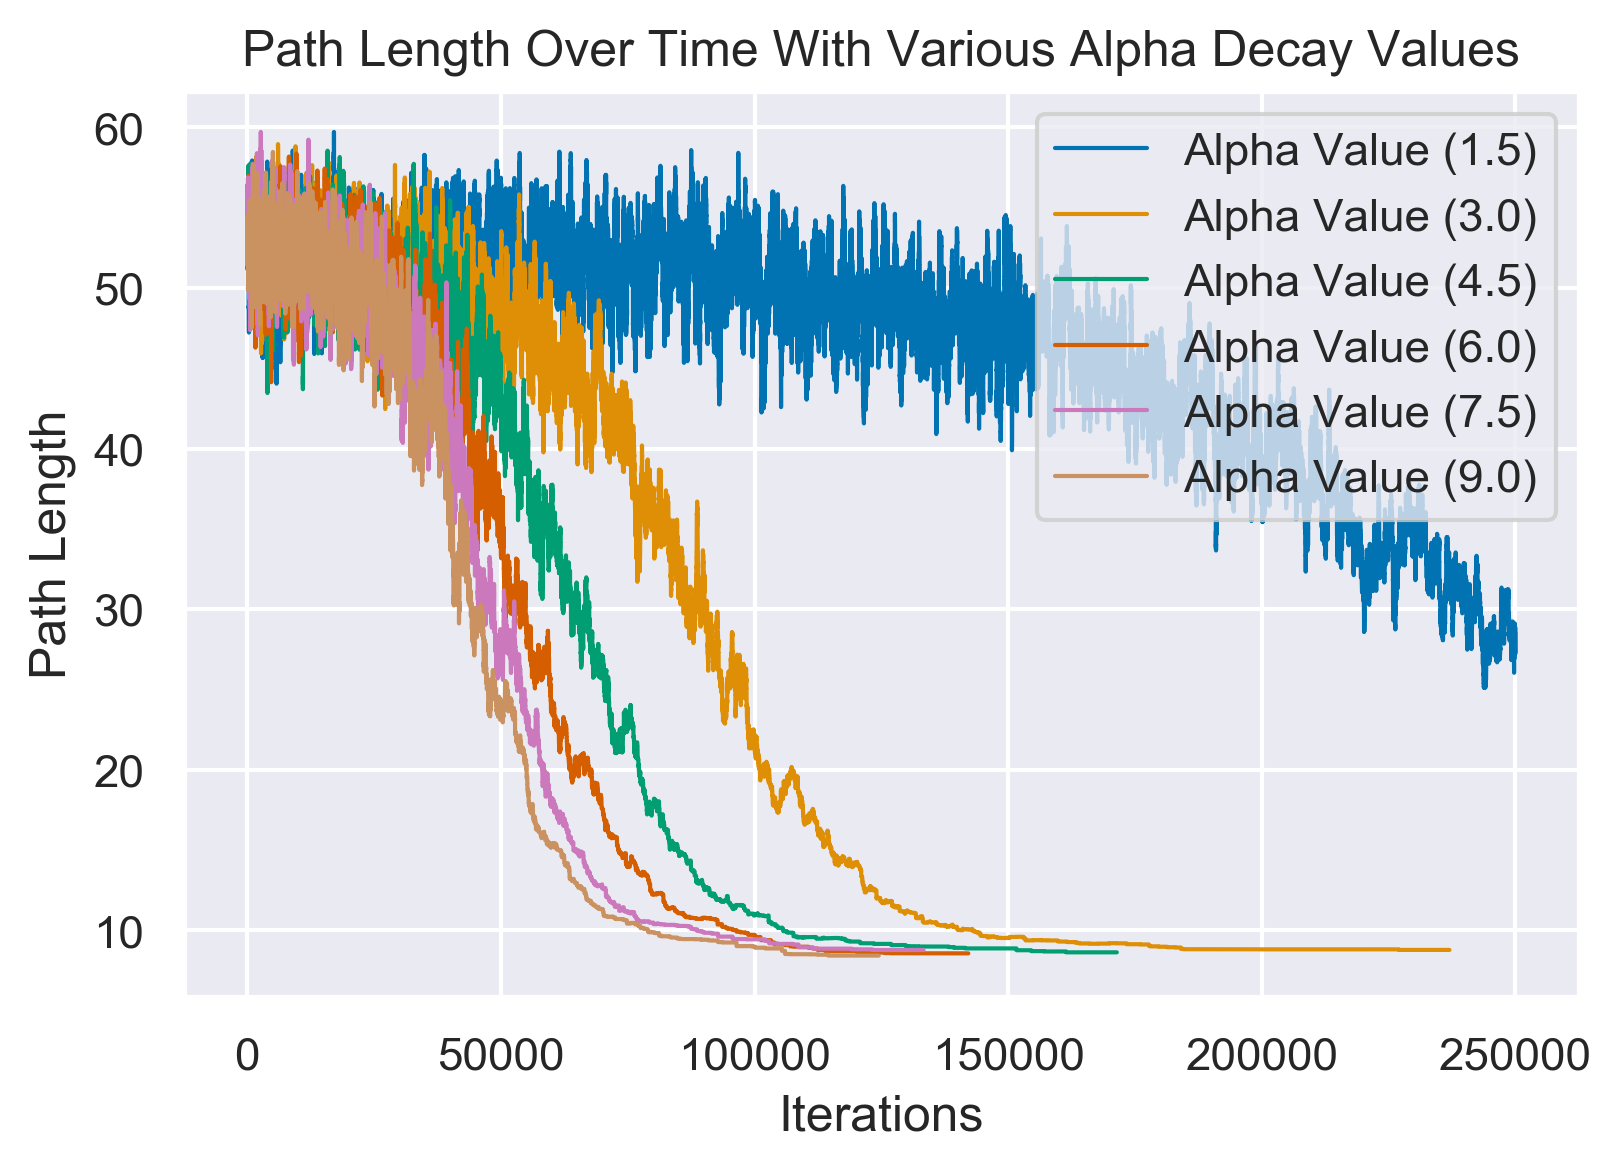

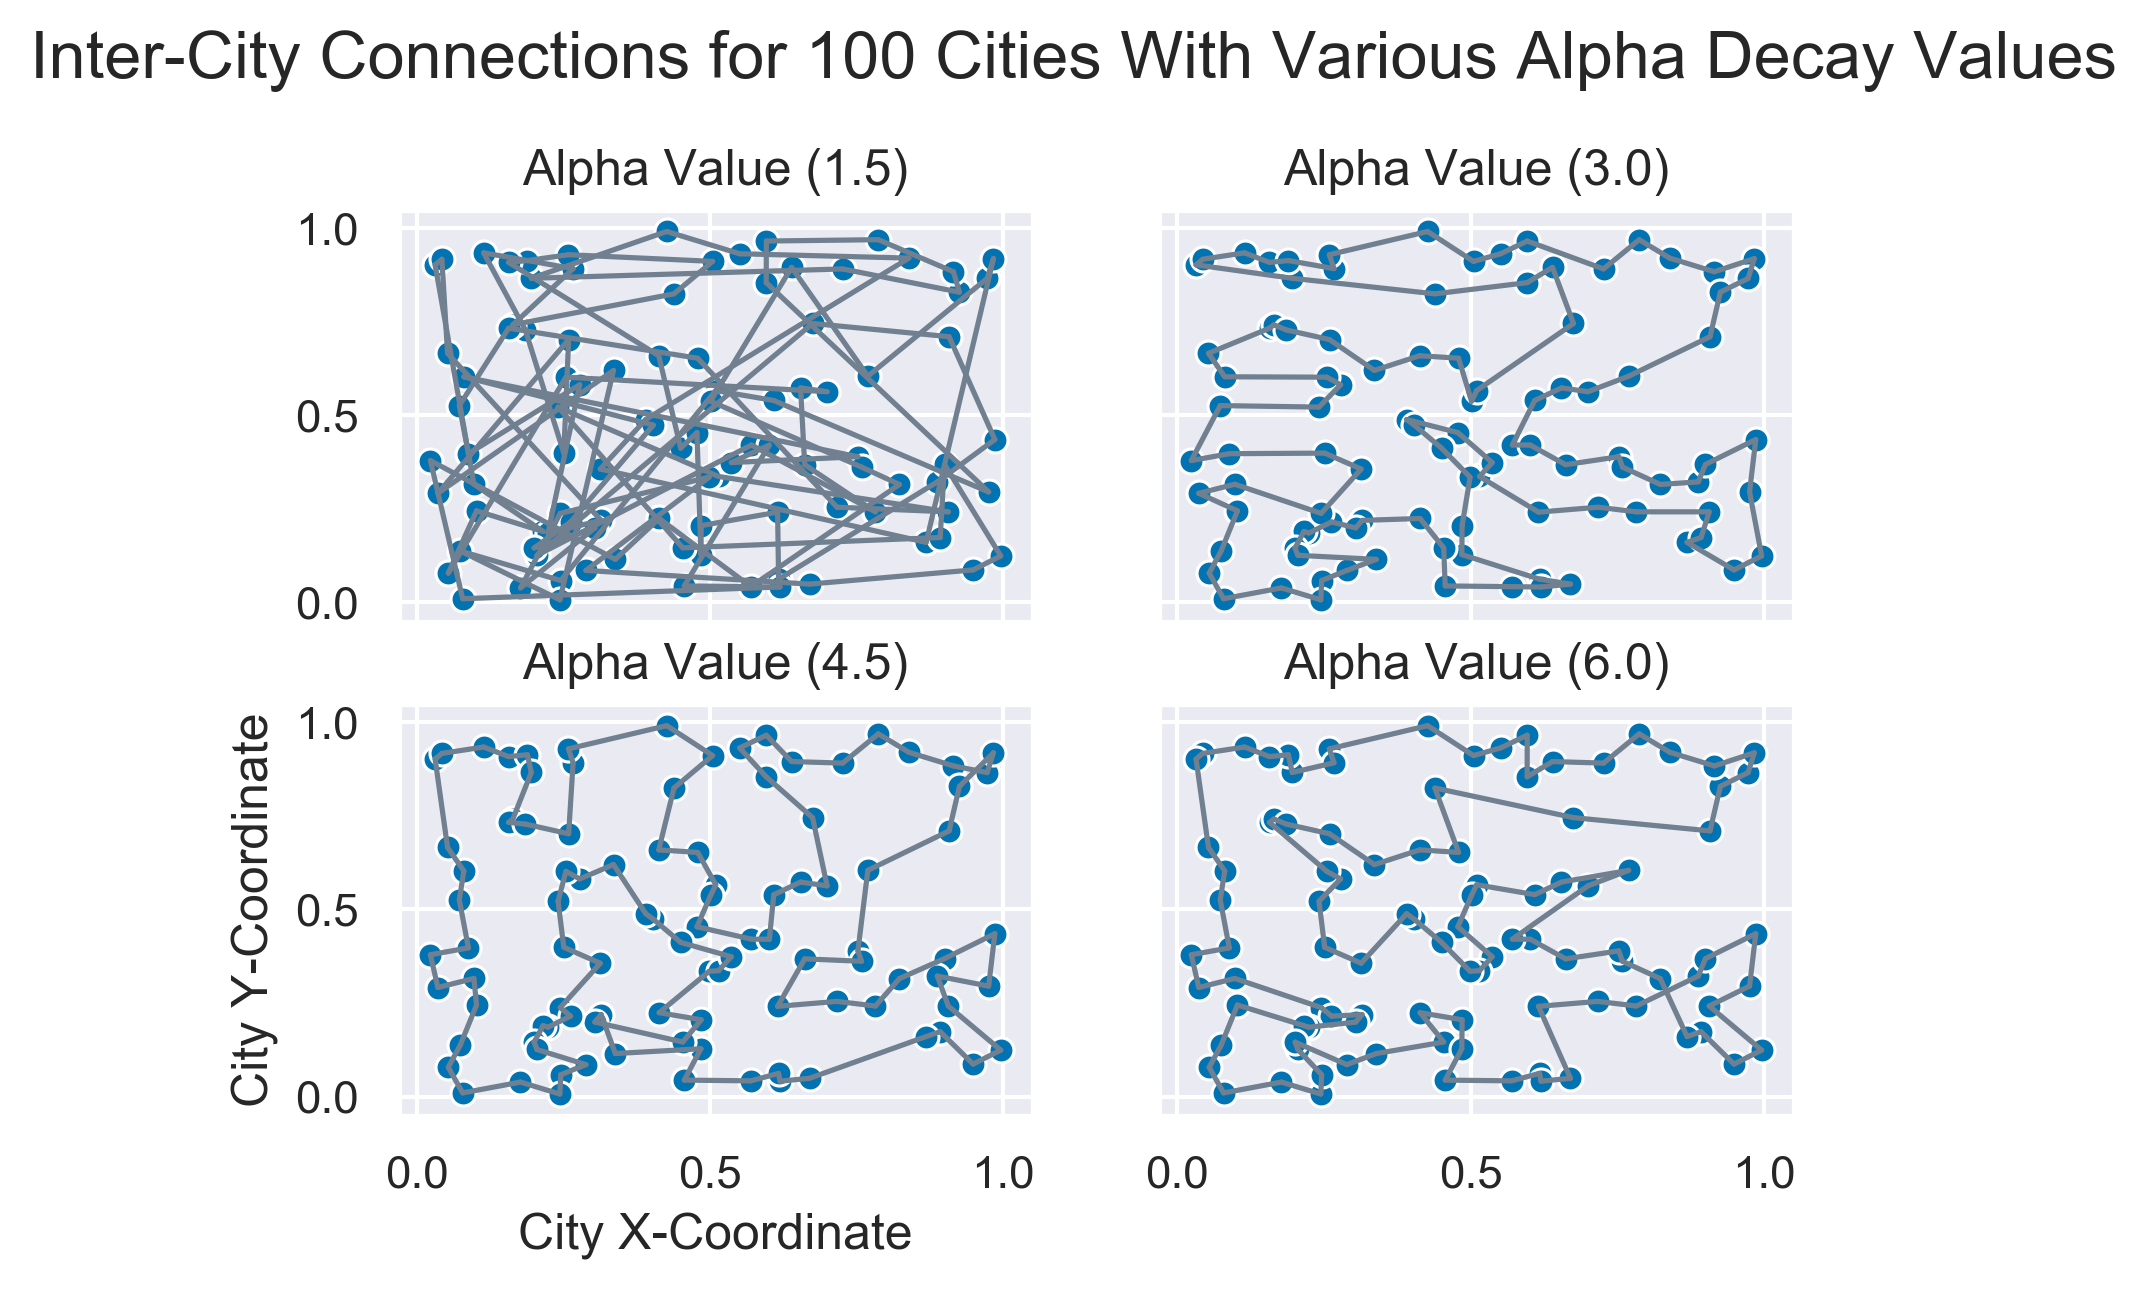

Wall time: 1min 55s


In [80]:
%%time

iterations = 250_000
early_stopping = 10_000

path_lengths = []
cities = []

base_city = generate_cities(n=100)

for alpha in np.arange(1.5, 10.5, 1.5):
    path, city = simulated_annealing(
        base_city,
        annealing_sub_tour,
        cooling_decay,
        finished_no_improvements,
        iterations=iterations,
        early_stopping=early_stopping,
        alpha=alpha,
    )

    path_lengths.append((path, f"Alpha Value ({alpha})"))
    cities.append((city, f"Alpha Value ({alpha})"))

print("Results For Each Algorithm...")
for path in path_lengths:
    print(f"{path[1]:16s} | Distance - {path[0][-1]:7.4f} | Iterations - {len(path[0]):d}")

plot_path_lengths(path_lengths, title="Various Alpha Decay Values")
plot_cities(cities[:4], suptitle="Various Alpha Decay Values")

# Conclusion

Based on my experiments, it would seem that the best hyperparameters would be a large alpha decay value along with a high initial temperature. Both cause the optimal path to emerge/converge faster.

The benchmark I used converged in $156867$ iterations with a final distance of $8.7390$. Using a higher alpha value and initial temperature, we hopefully approach the same distance in less iterations.

Final Results...
Distance -  8.6172 | Iterations - 60039


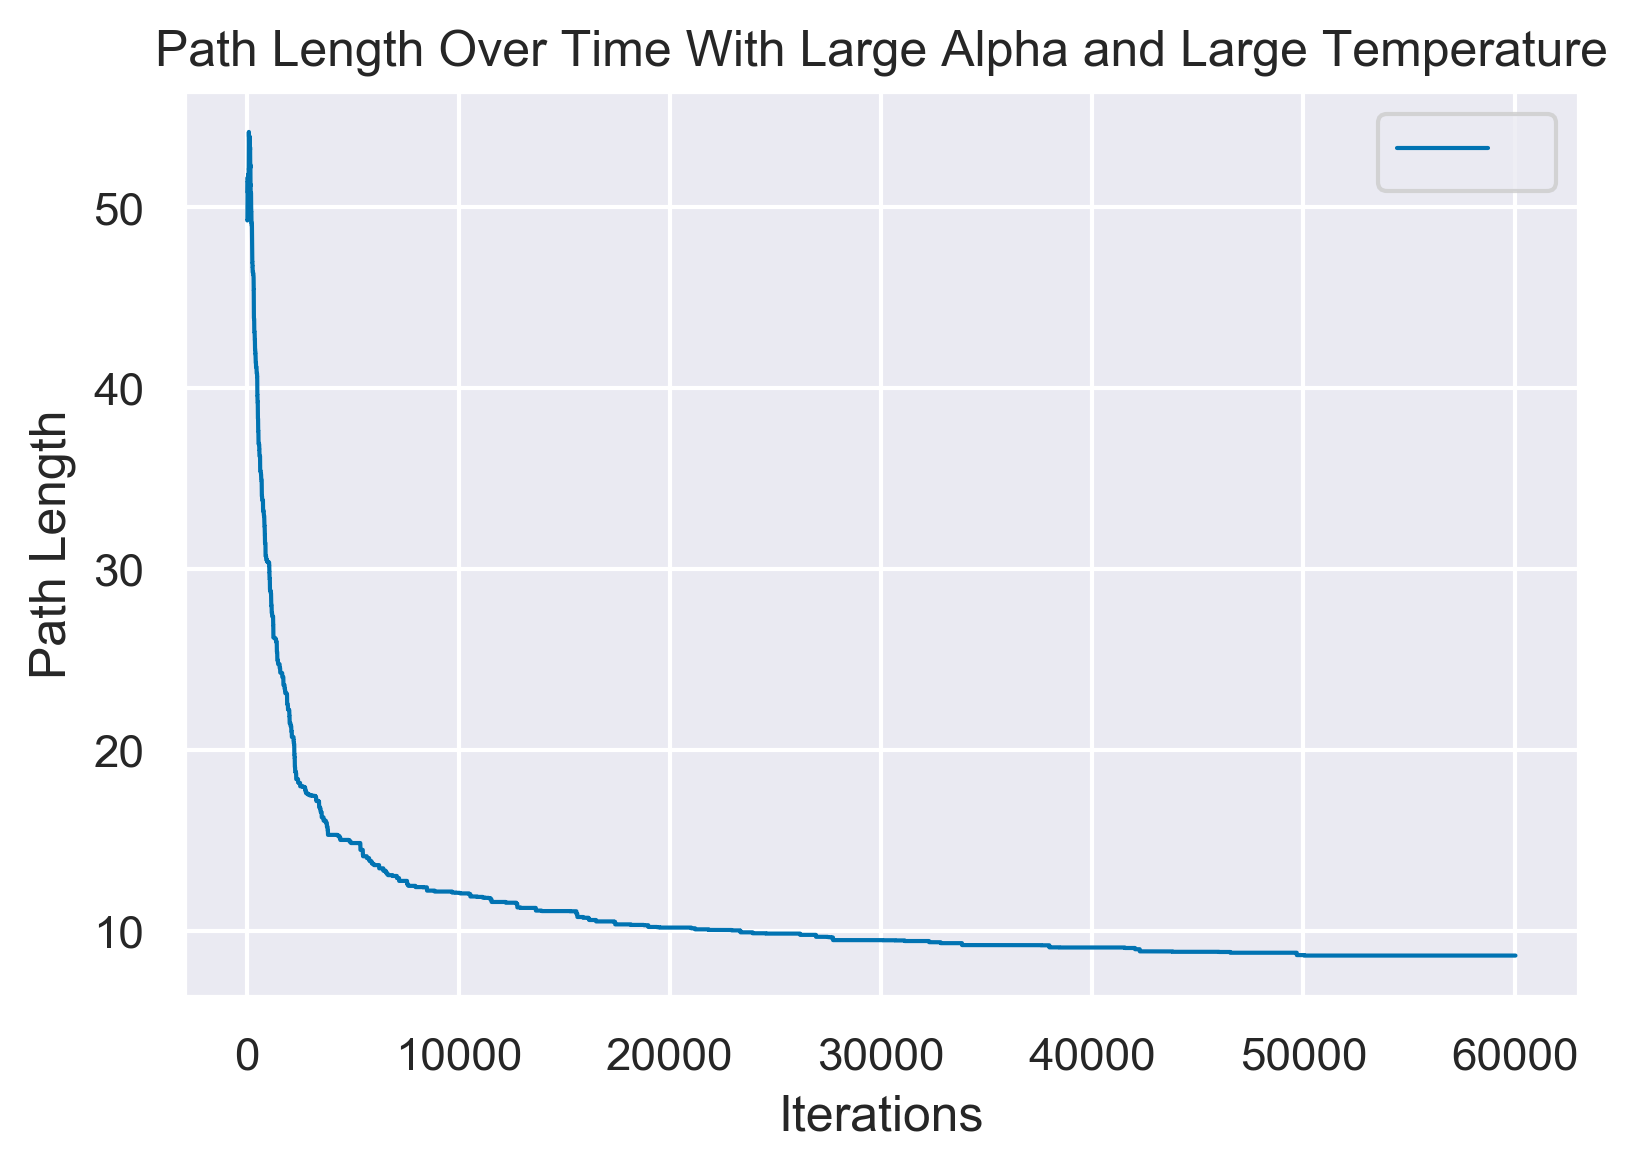

In [78]:
path, _ = simulated_annealing(
    base_city,
    annealing_sub_tour,
    cooling_decay,
    finished_no_improvements,
    iterations=iterations,
    early_stopping=early_stopping,
    temperature=2000,
    alpha=2000,
)

print("Final Results...")
print(f"Distance - {path[-1]:7.4f} | Iterations - {len(path):d}")

plot_path_lengths([(path, " ")], title="Large Alpha and Large Temperature")

# Discussion

Some of the variables I did not graph, such as temperature, were fairly boring hence the lack of visualizations. In the case of temperature, it pretty much was exactly the same as the path length graph, but just with a different y-axis and a smoother line. Run-time plots were also omitted because when cities doubled, the run-time did not change; the convergence speed was slower, but those graphs were already covered in the "city number" section. Although, the run-time did linearly scale with the number of iterations.

After finishing up my algorithms for annealing, I took a look at other approaches. For instance, I looked at https://github.com/chncyhn/simulated-annealing-tsp and noticed that they did essentially the same thing as me, albeit coded differently. The only real difference I could see is how acceptance is calculated. I simply used $p(accept) = e^{\frac{\Delta E}{T}}$ and calculated $\Delta E$ as the difference in path lengths as opposed to using $p(accept) = e^{\frac{-\Delta E}{T}}$ with $\Delta E$ being the absolute difference between path lengths. The final calculation was the same since if my path got worse, my $\Delta E$ turned negative and followed an identical calculation; the benefit of my approach is that if my path gets better, the formula will always accept it without checking extra conditions. They also had a minimum temperature, which mine did not. Based on my experiments with their code and mine, I cannot see a difference since they put their minimum to such a small value the acceptance probability was still nearly zero for worse paths.